In [1]:
import sys
sys.path.append('../')
import sqlite3
import pandas as pd 
import numpy as np 
import ta 
from backtester import *

In [2]:
conn = sqlite3.connect('../PriceData/PriceData_m5.db')
data = pd.read_sql("SELECT * FROM 'EUR/USD'", conn, parse_dates=['date'], index_col=['date'])
for col in ['open', 'close', 'high', 'low']:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
data

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,close,high,low
date,,,,,,,,,,,,,
2021-08-31 03:50:00,1.18172,1.18187,1.18188,1.18172,1.18185,1.18199,1.18201,1.18184,397,1.181785,1.181930,1.181945,1.181780
2021-08-31 03:55:00,1.18187,1.18189,1.18193,1.18174,1.18199,1.18201,1.18204,1.18187,429,1.181930,1.181950,1.181985,1.181805
2021-08-31 04:00:00,1.18189,1.18182,1.18190,1.18173,1.18201,1.18193,1.18201,1.18185,432,1.181950,1.181875,1.181955,1.181790
2021-08-31 04:05:00,1.18182,1.18191,1.18192,1.18178,1.18193,1.18204,1.18204,1.18191,294,1.181875,1.181975,1.181980,1.181845
2021-08-31 04:10:00,1.18191,1.18193,1.18201,1.18188,1.18204,1.18205,1.18213,1.18200,486,1.181975,1.181990,1.182070,1.181940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-18 13:15:00,1.15994,1.16033,1.16036,1.15994,1.16008,1.16044,1.16047,1.16008,1428,1.160010,1.160385,1.160415,1.160010
2021-10-18 13:20:00,1.16033,1.16071,1.16073,1.16033,1.16045,1.16084,1.16085,1.16044,1301,1.160390,1.160775,1.160790,1.160385
2021-10-18 13:25:00,1.16072,1.16103,1.16110,1.16063,1.16084,1.16115,1.16122,1.16075,1235,1.160780,1.161090,1.161160,1.160690


In [3]:
data['tsi'] = ta.momentum.tsi(data['close'], window_slow=70, window_fast=20, fillna=False)
data.dropna(axis=0, inplace=True)

<AxesSubplot:xlabel='date'>

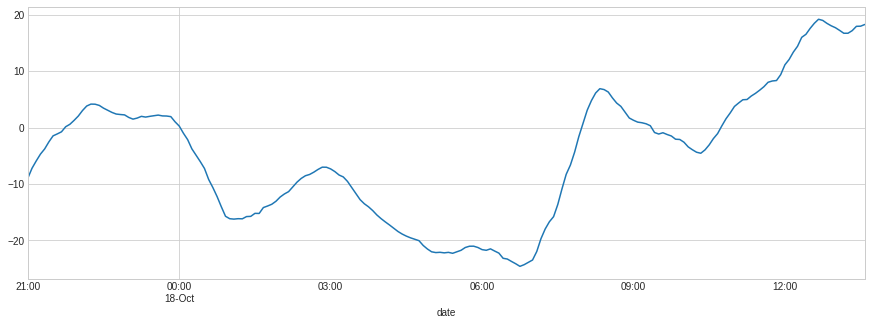

In [4]:
data['tsi'].iloc[-200:].plot(figsize=(15,5))

In [5]:
data['tsi'].describe()

count    9911.000000
mean       -1.242388
std        12.150398
min       -39.742778
25%        -8.912950
50%        -1.075799
75%         6.760392
max        41.378714
Name: tsi, dtype: float64

In [6]:
threshold = 30
print(f"Less than -threshold: {(data['tsi'] < -1*threshold).mean() * 100:.2f}%")
print(f"Greater than threshold: {(data['tsi'] > threshold).mean() * 100:.2f}%")

Less than -threshold: 1.38%
Greater than threshold: 0.53%


In [7]:
data['signal'] = np.where(data['tsi'] > threshold, -1,
                          np.where(data['tsi'] < -1*threshold, 1, np.nan))
data['signal'] = data['signal'].ffill().fillna(0)

In [8]:
data['signal'].value_counts()

 1.0    6168
-1.0    2421
 0.0    1322
Name: signal, dtype: int64

In [9]:
data['signal'].diff(1).apply(np.abs).value_counts()

0.0    9905
2.0       4
1.0       1
Name: signal, dtype: int64

  0%|          | 0/9910 [00:00<?, ?it/s]

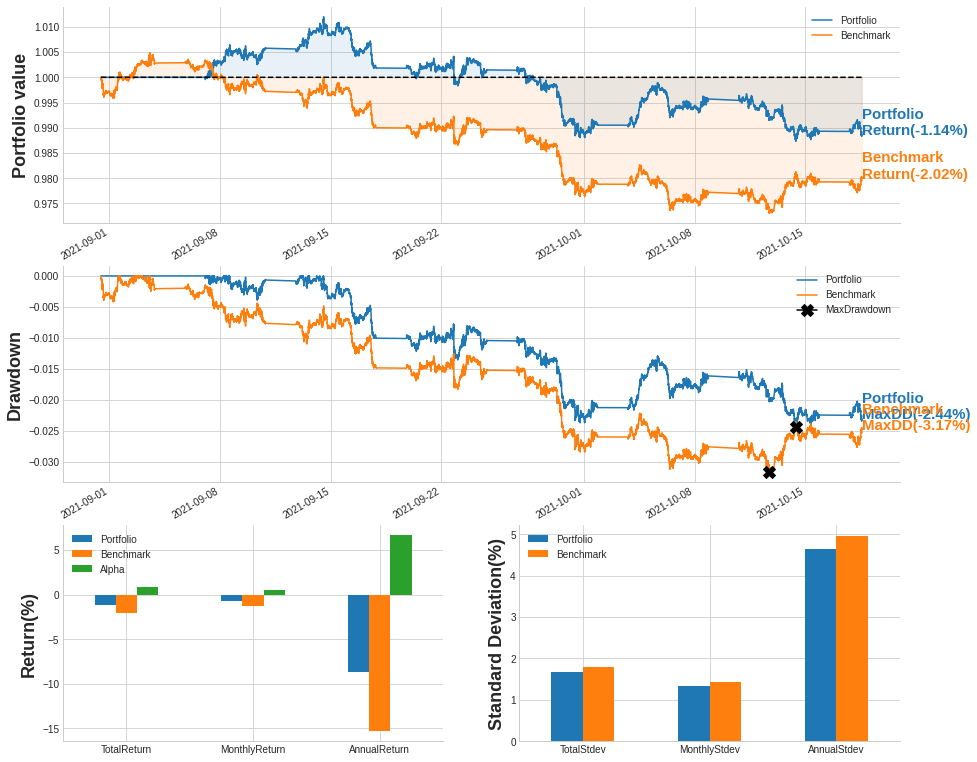

----------------------------------------------------------------------
Data length: |48 days 02:20:00|
Data range from |2021-08-31 11:15:00| to |2021-10-18 13:35:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -1.141 │      -2.021 │   0.880 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -0.712 │      -1.260 │   0.549 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      -8.658 │     -15.335 │   6.678 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [10]:
backtest = IterativeBacktester(data, data['signal'], 'm5')
backtest.backtest()
backtest.results()